# Tutorial: Language: in the search of neural code

Please download the relevant data and install the required packages for this tutorial by running the following 2 cells:

In [5]:
# @title Download data
from pathlib import Path
if not Path("data").exists():
  !gdown --folder --id 1DjONQkI2m2_cJ6k-bc4ahgmCoFlCi97w -O data

if not Path("data/libribrain2025_data").exists():
  !unzip -q data/libribrain2025_data.zip -d data/libribrain2025_data

[i for i in Path("data").glob("*")]

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Retrieving folder contents
Retrieving folder 1jXGVUah_U8Qd-vZrzPPO5fK466TZ2A77 images
Processing file 1T-FgNFXLwVA1qgL_HeaWfk9DUZ9YSGjY ENS_PSL.jpg
Processing file 1-LTZ0CmquTcNWsgXmoIINlLTdKfZVyIZ LucyZhang.jpg
Processing file 14dhjtjtvEycvkfWHMy4Nj0-hwnuQXYmx Meta_lockup_positive primary_RGB.png
Processing file 1B0SRpkjUdOU1pALrnoSIJvQjqRKa6_h6 part1_decoding.PNG
Processing file 15l8mmP0QdTh3-poRgRios7hnRCzwFnRU part1_example_output.png
Processing file 1j-k2WfPoskGU7EinuH0iILCaqrn6TtDg part1_word_decoding.PNG
Processing file 1mB9pBc_iTcVpjWcubhG67IfP81vO9wap profile_banville.jpg
Processing file 1grLs9brJOPhNg8jk6-cUwnuDaptlNnQe profile_evanson.png
Processing file 1dA_dBfbTqJfUvudl5LCMfeq7QE7V6mAQ rothschild_logo.png
Processing file 1jkadTwM2FbAojuwjRw_KdMpDoni7l4Xz l

[PosixPath('data/libribrain2025_data.zip'),
 PosixPath('data/libribrain2025_data'),
 PosixPath('data/utils.py'),
 PosixPath('data/images')]

In [6]:
# @title Install required packages
!pip install mne;
!pip install wordfreq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00


In [23]:
# @title Util functions
import matplotlib.pyplot as plt
import numpy as np


def get_example_data(events, raw, session):
    """
    Get 3 example channels and 10 events to plot
    """
    # Select 10 events to visualise
    example_events = events.query("session==@session and type=='Word'").iloc[:10]

    # Get the tmin and tmax of these 10 events
    try:
      tmin = example_events.start.min().item() - 0.2 # 0.2 sec before word occurs
      tmax =  example_events.start.max().item() + example_events[example_events.start==example_events.start.max()].duration.item() + 0.2
    except:
      tmin = example_events.start.min() - 0.2 # 0.2 sec before word occurs
      tmax =  example_events.start.max() + example_events[example_events.start==example_events.start.max()].duration.item() + 0.2

    # Get neural signal in this time window (and just 3 example channels to visualise)
    example_channel_names = ["MEG 0112", "MEG 0123", "MEG 0133"]
    neural_data = raw.copy().crop(tmin, tmax).pick(example_channel_names).get_data()
    times = np.arange(tmin, tmax+1/raw.info["sfreq"], 1/raw.info["sfreq"])

    return example_events, example_channel_names, neural_data, times

def visualise_events(events, raw, session="", plot_zipfreq=False, plot_neural=True, plot_zipf_analogue=False):
    """
    Plot 10 events and 3 example channels
    """
    example_events, example_channel_names, neural_data, times = get_example_data(events, raw, session)

    fig, ax = plt.subplots(figsize=(10, 4))

    yaxis = "zipfreq" if plot_zipfreq else "text"

    # Plot horizontal bars for events
    ax.barh(example_events[yaxis], example_events['duration'], left=example_events['start'],
            height=0.4, color='skyblue', label='Events');

    if plot_zipfreq: # label words
        for _, word in example_events.iterrows():
            ax.text(word.start, word.zipfreq, word.text)

    if plot_zipf_analogue:
        signal = np.zeros_like(times)

        # Create signal from events
        for _, row in example_events.iterrows():
            start_idx = np.searchsorted(times, row['start'])
            end_idx = np.searchsorted(times, row['start'] + row['duration'])
            signal[start_idx:end_idx] = row['zipfreq']
        ax.plot(times, signal, label="zipfreq", color="grey")

    # Label and grid
    ax.set_xlabel("Time (s)")
    ax.set_ylabel(yaxis.capitalize())
    ax.set_title("Events and Neural Signal")
    ax.grid(True, axis='x')

    # Twin axis for neural data
    ax2 = ax.twinx();
    ax.set_zorder(2)        # Main axis in front
    ax2.set_zorder(1)       # Secondary axis in back
    ax.patch.set_visible(False)  # Make background of ax transparent to reveal ax2

    if plot_neural:
        for n, name, color in zip(neural_data, example_channel_names, ["#f87171",  "#ef4444",   "#b91c1c"]):
            ax2.plot(times, n, color=color, label=name, lw=0.5)
        ax2.set_yticks([])  # Hide secondary y-axis ticks
        ax2.set_ylabel("Neural Activity (a.u.)")

    # Combine legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    loc = "lower right"
    ax2.legend(lines1 + lines2, labels1 + labels2, loc=loc)

    plt.tight_layout()
    plt.show()


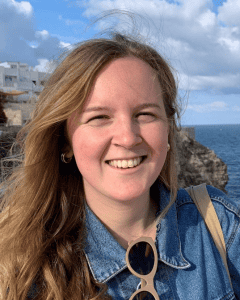
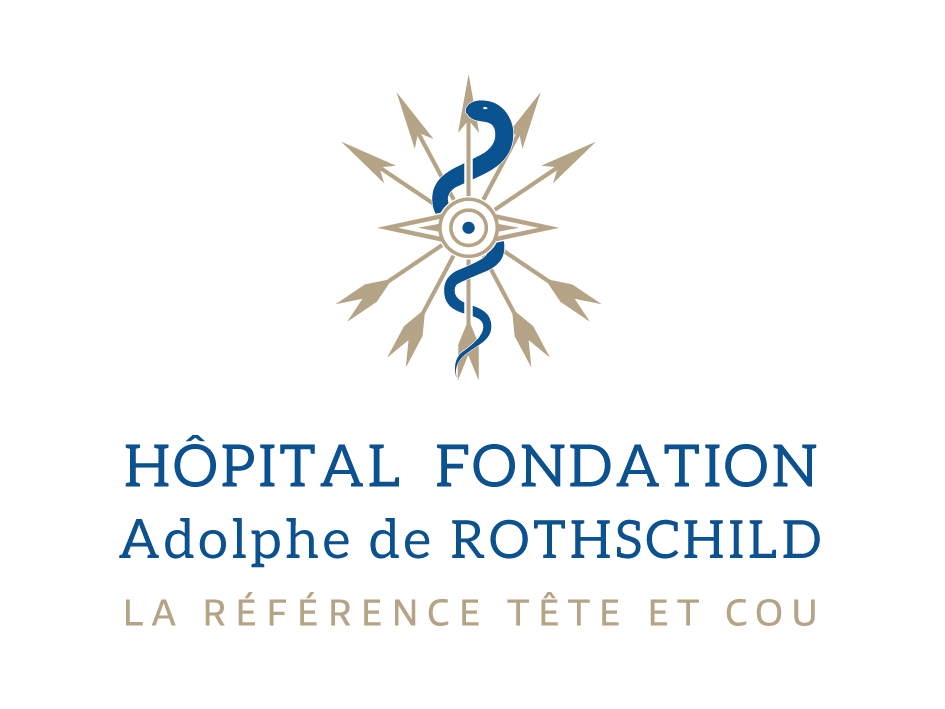

In [3]:
#@title Intro
from IPython.display import display, HTML
from base64 import b64encode

# Main profile image path
main_path = "images/profile_evanson.png"

# Two small logos paths
logo1_path = "images/Meta_lockup_positive primary_RGB.png" # Replace with actual paths
logo2_path = "images/rothschild_logo.png"

# Encode images in base64
def encode_img(path):
    with open(path, "rb") as f:
        return b64encode(f.read()).decode("utf-8")

main_img = encode_img(main_path)
logo1_img = encode_img(logo1_path)
logo2_img = encode_img(logo2_path)

html = f"""
<div style="display: flex; align-items: flex-start; justify-content: space-between;">
    <!-- Left side: profile image and text -->
    <div style="display: flex; align-items: flex-start;">
        <img src="data:image/png;base64,{main_img}" width="200" style="margin-right: 20px;"/>
        <div style="font-size: 24px; font-weight: bold; margin-bottom: 8px;">
            <b>Part 1: Linear Decoding</b><br>
            <div style="font-size: 18px; line-height: 1.5; font-weight: normal;">
                Linnea Evanson, PhD<br>
                Postdoc at Rothschild Foundation Hospital. Previously @MetaAI as a Research Intern.<br><br>
                Relevant <a href="https://scontent-cdg4-2.xx.fbcdn.net/v/t39.2365-6/497635895_1416828025978405_6687721506010334726_n.pdf?_nc_cat=100&ccb=1-7&_nc_sid=3c67a6&_nc_ohc=hh5qWVa8BS0Q7kNvwHMdq2u&_nc_oc=AdkioyBW072oV6OwbnYxTrLXQqHbGLHn6MsTm5pP79SVAouRDBwy7j4ArLTsjsmuR7U&_nc_zt=14&_nc_ht=scontent-cdg4-2.xx&_nc_gid=61wrENL-7sXi0dWEn9jFag&oh=00_AfXL72-uPD8uIkyrVPbQCh2eE0mqmLzCVERKiFc5r7pCjw&oe=689BB1A4" target="_blank">paper</a>: <br>
                "Emergence of language in the developing brain"<br>
                An sEEG study in children as young as 2 years old, investigating representations of language through de/encoding analyses.<br><br>
                Keep in touch: <a href="https://x.com/EvansonLinnea" target="_blank">X</a>,
                               <a href="https://www.linkedin.com/in/linnea-evanson/" target="_blank">Linkedin</a>,
                               <a href="https://scholar.google.com/citations?user=VgTpOTIAAAAJ&hl=en" target="_blank">Scholar</a>,
            </div>
        </div>
    </div>

    <!-- Right side: two small logos -->
    # <div style="display: flex; flex-direction: column; gap: 10px; margin-left: 20px;">
    <div style="display: flex; flex-direction: column; gap: 10px; margin-left: 20px; align-items: center;">

        <img src="data:image/png;base64,{logo1_img}" width="200" style="object-fit: contain;" />
        <img src="data:image/png;base64,{logo2_img}" width="100" style="object-fit: contain;" />
    </div>
</div>
"""

display(HTML(html))


### Goal of this tutorial

**Question:** What kind of information does the brain represent? \
For example, does the brain represent word information? What about word frequency information?

**Solution**: decoding allows us to investigate the representations present in neural data.

### Overview of this tutorial

Part 1) Linear decoding over time (30 mins) \
Part 2) Modular experimental design and caching (30 mins) \
Part 3) Deep decoding (30 mins)

### What is decoding?



We fit a model $f$, given $x$ to predict $y$. \
$x$ is the neural data and $y$ is the feature describing the stimulus. \
The model $f$ could be linear (eg. a ridge regression) or deep (a conv net, a transformer, whatever you like).

We evaluate the model by finding the correlation between the feature predicted by the model ($y_{pred}$) and the true feature ($y$).



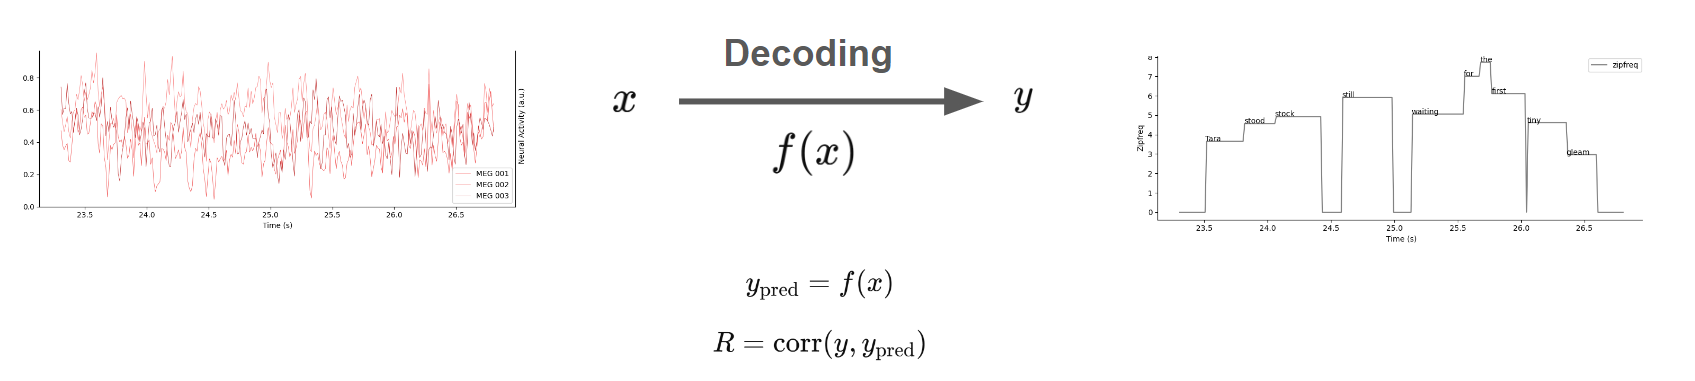

In [5]:
from IPython.display import Image
Image(filename="images/part1_decoding.PNG")

 ### What can decoding tell us?
- Which features are represented in the brain.
- If they are linearly decodable.
- The dynamics of these representations.

### How do we investigate dynamics?

We can fit and evaluate such a model over different timesteps, to see how well a representation is decoded at each timestep.

For example, in "Emergence of language in the developing brain" (Evanson et al, 2025) https://ai.meta.com/research/publications/emergence-of-language-in-the-developing-brain/, \
we presented an audiobook to participants and then investigated neural representations around the onset of each word. \

We fit one linear regression at each timestep, from [-2, 3s], we here plot the correlation value at each timestep. \
We do this seperately for a variety of features ($y$), such as nouns (where $y$ takes value 0 when a noun is present, and 0 when it is not present) and verbs.

We observe that the brain does represent word information and that information is present for around 1.5 seconds after the word onset (t=0).




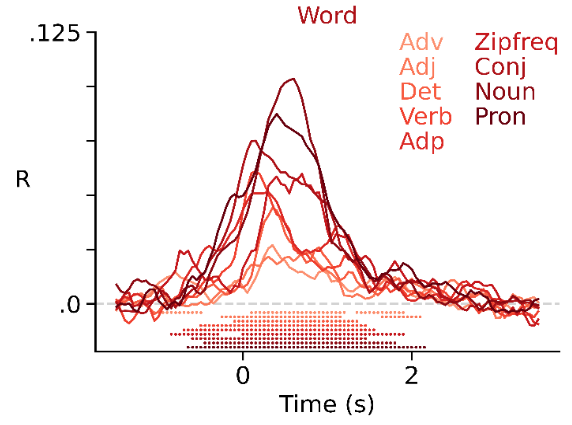

In [6]:
Image("images/part1_word_decoding.PNG")

Example output for Part 1 \

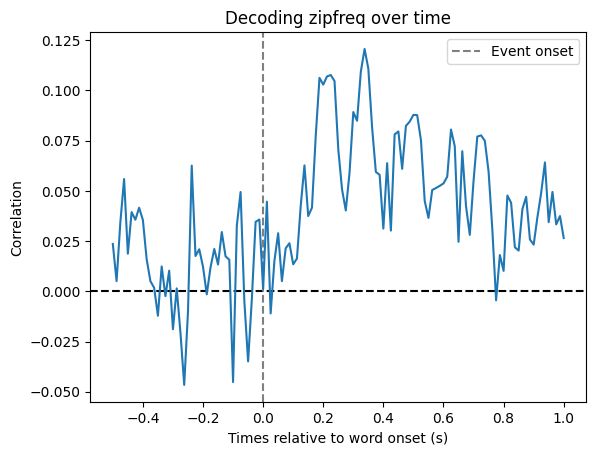

In [7]:
Image("images/part1_example_output.png")

# Part 1: Linear decoding

Contents:
1. Load and explore the data
2. Preparing the data
3. Decoding
4. Structuring the code



If you haven't already done so, download the relevant data to the colab instance (first cell in this notebook).

### 1. Load and explore the data

In this tutorial we are using a subset of the data presented in "LibriBrain: Over 50 Hours of Within-Subject MEG to Improve Speech Decoding Methods at Scale" (Özdogan et al, 2025, https://arxiv.org/abs/2506.02098).

Key facts:
- MEG recordings
- Naturalistic language stimuli (Sherlock homes audiobooks)
- Publically available (https://huggingface.co/datasets/pnpl/LibriBrain)
- Now part of a language decoding competition: https://neural-processing-lab.github.io/2025-libribrain-competition/.
- Here we analyse only limited sessions from a single participant!



In [12]:
import pandas as pd
from pathlib import Path
import numpy as np
import mne
import matplotlib.pyplot as plt
%xmode Plain

Exception reporting mode: Plain


In [8]:
preproc_path = Path("data/libribrain2025_data/")
assert preproc_path.exists()

NameError: name 'Path' is not defined

What's in the data folder?

In [16]:
[i.name for i in preproc_path.glob("*")]

['LibriBrain2025_subject-0_session-1_run-1_task-Sherlock1_preproc.fif',
 'LibriBrain2025_subject-0_session-1_run-1_task-Sherlock7_preproc.fif',
 'LibriBrain2025_subject-0_session-1_run-1_task-Sherlock2_preproc.fif',
 'events.csv',
 'LibriBrain2025_subject-0_session-1_run-1_task-Sherlock3_preproc.fif',
 'LibriBrain2025_subject-0_session-1_run-1_task-Sherlock6_preproc.fif',
 'LibriBrain2025_subject-0_session-1_run-1_task-Sherlock5_preproc.fif',
 'LibriBrain2025_subject-0_session-1_run-1_task-Sherlock4_preproc.fif']

We see the data seems to be organised into different sessions. Neural data is stored in .fif files, and information about the events (the stimulus presented) is in a csv.\
Let's check out the events dataframe:

In [17]:
events = pd.read_csv(preproc_path / "events.csv").drop(columns="Unnamed: 0")
events.head()

,type,start,duration,session,text,task
0,Meg,0.000,1112.000068,LibriBrain2025_subject-0_session-1_run-1_task-...,NaN,Sherlock1
1,Word,30.086,0.100000,LibriBrain2025_subject-0_session-1_run-1_task-...,a,Sherlock1
2,Word,30.186,0.370000,LibriBrain2025_subject-0_session-1_run-1_task-...,study,Sherlock1
3,Word,30.556,0.140000,LibriBrain2025_subject-0_session-1_run-1_task-...,in,Sherlock1
4,Word,30.696,0.590000,LibriBrain2025_subject-0_session-1_run-1_task-...,scarlet,Sherlock1


We see there are 'Meg' events and 'Word' events.
All the words that were presented to the participant are listed for each session. Let's checkout some statistics about the events: Number of sessions? Number of words presented?

In [18]:
print("n session (number of neural files):", events.session.nunique(),
"\ntypes of events:", events.type.unique(),
"\nn words per session:", events.query("type=='Word'").groupby("session").text.count().mean(),
"\naverage duration of words:", events.query("type=='Word'").duration.mean(), "seconds")

n session (number of neural files): 7 
types of events: ['Meg' 'Word'] 
n words per session: 5493.0 
average duration of words: 0.2782286546513744 seconds


Let's load an example meg file and plot the data

In [19]:
session = "LibriBrain2025_subject-0_session-1_run-1_task-Sherlock1"
raw = mne.io.read_raw(preproc_path / f"{session}_preproc.fif")

Opening raw data file data/libribrain2025_data/LibriBrain2025_subject-0_session-1_run-1_task-Sherlock1_preproc.fif...
Isotrak not found
    Range : 0 ... 88959 =      0.000 ...  1111.987 secs
Ready.


/tmp/ipython-input-2698765919.py:2: RuntimeWarning: This filename (data/libribrain2025_data/LibriBrain2025_subject-0_session-1_run-1_task-Sherlock1_preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(preproc_path / f"{session}_preproc.fif")


Using matplotlib as 2D backend.


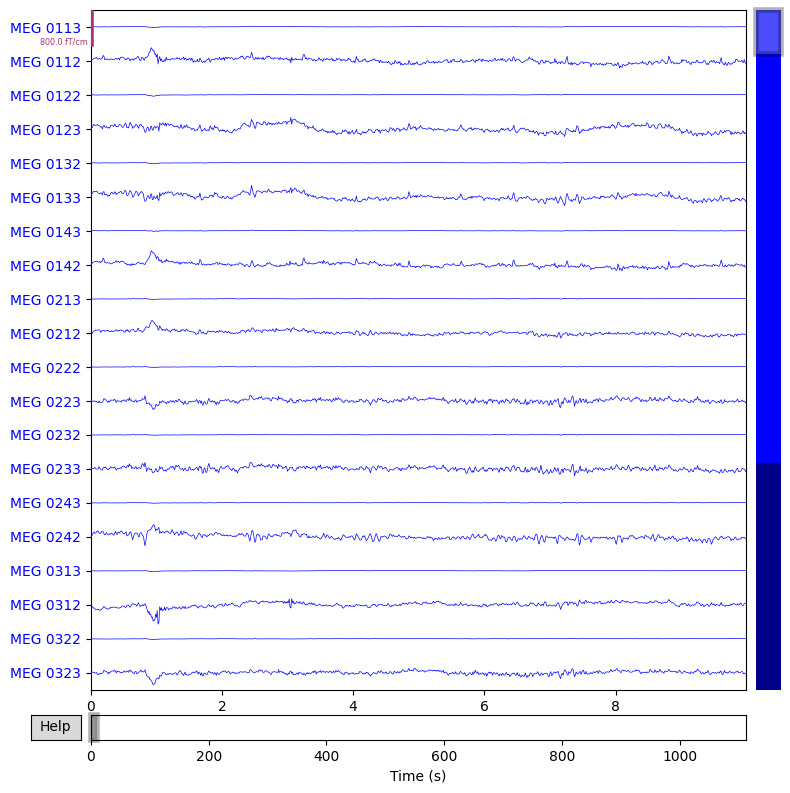

In [20]:
raw.plot();

How do the events line up with the neural responses? Let's visualise this.

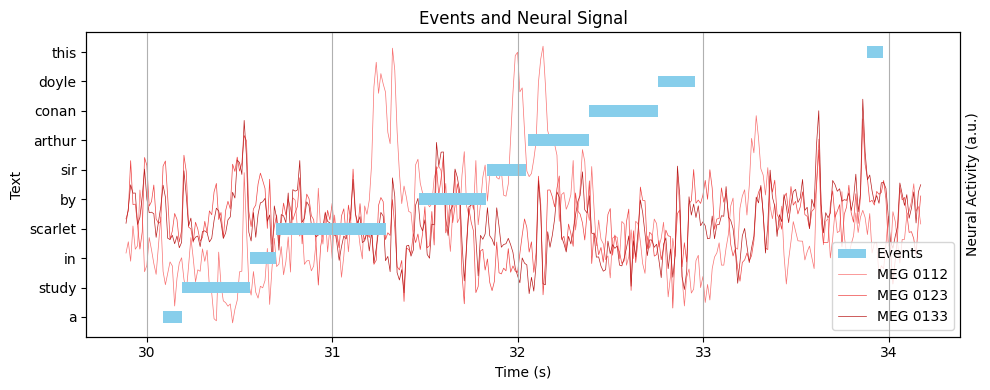

In [24]:
visualise_events(events, raw, session=session)

### 2. Preparing the data (x: neural and y: feature)

Now that we understand how our dataset is structured it's time to prepare our inputs. We need to

A) Filter the neural data

In [25]:
def prepare_neuro(session):
    """
    Relevant mne tutorial:
    https://mne.tools/stable/auto_tutorials/preprocessing/30_filtering_resampling.html

    """
    file= Path(preproc_path) / f"{session}_preproc.fif"

    if file.exists():
        raw = mne.io.read_raw(file)

    else:
        fmin = 0.05
        fmax = 40.
        freq = 80.

        original_file = preproc_path / f"{session}.fif" # original file
        raw = mne.io.read_raw(original_file)
        raw = raw.pick(picks=["meg"]) # don't want to analyse misc

        # band pass filter
        raw = raw.filter(fmin, fmax)

        # downsample
        if freq != raw.info["sfreq"]:
            raw = raw.resample(freq)

        # save
        raw.save(file, overwrite=False)

    return raw

session =  "LibriBrain2025_subject-0_session-1_run-1_task-Sherlock1"
raw = prepare_neuro(session)


Opening raw data file data/libribrain2025_data/LibriBrain2025_subject-0_session-1_run-1_task-Sherlock1_preproc.fif...
Isotrak not found
    Range : 0 ... 88959 =      0.000 ...  1111.987 secs
Ready.


/tmp/ipython-input-3751205807.py:10: RuntimeWarning: This filename (data/libribrain2025_data/LibriBrain2025_subject-0_session-1_run-1_task-Sherlock1_preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(file)


B) Compute the feature of interest

Rather than decoding the word itself as a classification task, we want to decode a feature characterising some aspect of the words. \
Here we choose zipf frequency: the logarithm of the frequency of words in natural language.    


In [26]:
from wordfreq import zipf_frequency

def get_word_freq(word: str) -> float:
    return zipf_frequency(word.lower(), 'en')

events = pd.read_csv(preproc_path / "events.csv")

# Select the words in the relevant session
words = events[(events['type'] == 'Word') & (events['session'] == session)].dropna().reset_index(drop=True)
words['zipfreq'] = words.text.apply(get_word_freq)


feature_array = words.zipfreq.values
print("\nfeature_array: (n_words, n_dims)", feature_array.shape)


feature_array: (n_words, n_dims) (2836,)


For zipfreq ndims=1, but for other features (eg. a word embedding) ndims could be > 1.

What does this zipfreq look like for our example sentence?

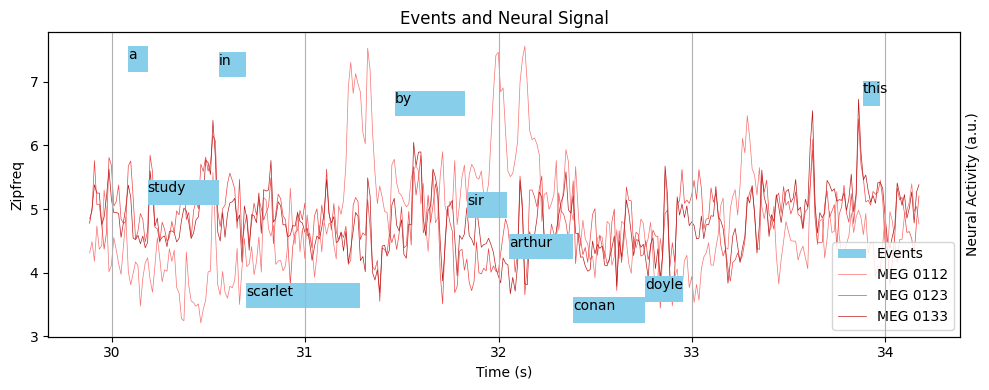

In [27]:
visualise_events(words.iloc[:10], raw, session=session, plot_zipfreq=True)

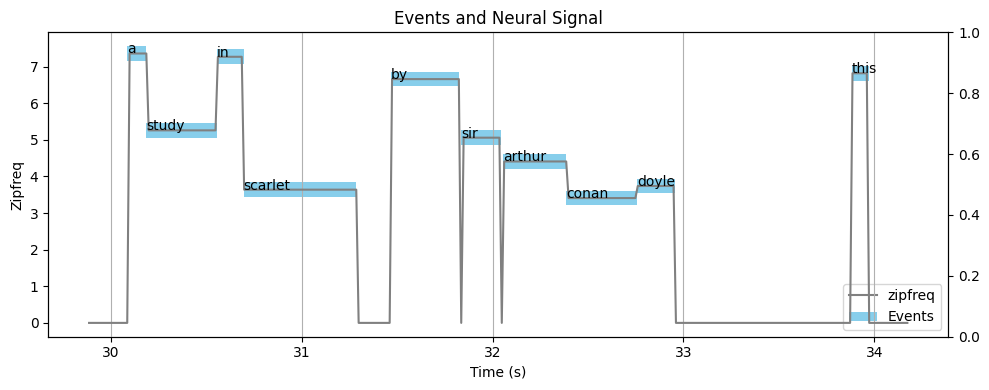

In [28]:
visualise_events(words.iloc[:10], raw, session=session, plot_zipfreq=True, plot_neural=False, plot_zipf_analogue=True)

C) We need to segment the neural data around the onset of each word.

We set a window (tmin, tmax) around each word to segement. \
The mne.Epochs object segments the neural data, and stacks those segments (1 per word).

**Question:** What would be an appropriate time window to decode over?

In [ ]:
## Adjust this to decode over a larger/smaller window
tmin = ???
tmax = ???

In [ ]:
# Get word onsets in samples
word_onsets = np.ones((len(words), 3), dtype=int) # mne.epochs expects events of shape (n_events, 3) but we are only interested in the first column here -> set the rest to 0
word_onsets[:, 0] = words.start *raw.info["sfreq"] # first column must contain the onset of each event (word) in samples

# Segment
segments = mne.Epochs(
    raw,
    word_onsets,
    metadata=words,
    event_repeated="drop",
    baseline=(-0.2, 0),  # setting a baseline (-0.2, 0) can improve decoding results. Baselining subtracts the mean value over this window from the entire segment.
    tmin=tmin,
    tmax=tmax,
)

# from mne to numpy
neuro_array = segments.get_data()

# clip segments to prevent outliers impacting regression
neuro_array = np.clip(neuro_array, a_min=-20, a_max=20)

print("\n\nneuro_array: n_segments (n_words), n_channels, n_times", neuro_array.shape)

# Get the words aligned with the mne segments
feature_array = segments.metadata["zipfreq"].values.reshape(-1,1)  # change from (n_words,) to (n_words, 1)

**Question:** Does our segmented neural data and feature (zipfreq) share any dimension? What does that dimension represent? \
Write an assert to verify that.

In [ ]:
#@title Answer
assert neuro_array.shape[0] == feature_array.shape[0] # same number of words

print("neuro_array: n_words, n_channels, n_times", neuro_array.shape, "\nfeature_array: n_words, n_dims", feature_array.shape)

What does this segmented neural data look like?  ...we see activation in response to a word (presented at t=0)

In [ ]:
segments.average().plot(); # we average over all the words, plotting one line per channel

### 3. Decoding

Now that we've prepared everything, it's time to fit a model given neural data ($X$), to predict our feature of interest ($y$). We will then evaluate the performance of this model by computing the correlation between the true ($y$) and predicted ($y_{pred}$) feature.

$y_{pred} = f(X) $ \
$R = corr(y, y_{pred})$


In order to fairly evaluate the model we use cross validation (cv) splits: fitting the model on a portion (n) of the data, and evaluating on the rest (1-n). \
We use RidgeCV from sklearn to implement this.

**Note! In order to get a decoding curve over time, we fit and evaluate a model per timestep.** \
We iterate over timesteps (t), selecting the neural data at that timestep: X[:, :, t]. \
Meaning x will be of shape n_words, n_channels.

In [ ]:
from scipy.stats import pearsonr
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from tqdm import trange

Remind ourselves the dimensions of our X (neuro_array) and y (feature_array)

In [ ]:
assert neuro_array.shape[0] == feature_array.shape[0] # same number of words
print("neuro_array: n_words, n_channels, n_times", neuro_array.shape, "\nfeature_array: n_words, n_dims", feature_array.shape)

In [ ]:
n_folds = 2  # number of cv splits

**Question:** what is the expected dimension of the correlation array r in the following loop? -> Initialise r_scores.

In [ ]:
#@title Answer
# r_scores = np.zeros((cv.n_splits, n_times, n_dims))  # as we are looping over cv splits, timesteps, and then find a correlation per dimension of the feature (here n_dims=1)

In [ ]:
n_words, n_channels, n_times = neuro_array.shape
n_words, n_dims = feature_array.shape

# init model
model = make_pipeline(StandardScaler(), Ridge(alpha=1e4))

# init cross validation
cv = KFold(n_folds, shuffle=False)  # shuffle false to keep overlapping segments in same cv split

# experiment loop
r_scores = ??
for split, (train, test) in enumerate(cv.split(neuro_array)):
    for t in trange(n_times, desc=f"split {split}/{cv.n_splits}"):
        model.fit(X=neuro_array[train, :, t], y=feature_array[train])
        preds = model.predict(X=neuro_array[test, :, t])
        preds = preds.reshape(-1, 1) if preds.ndim==1 else preds

        for d in range(n_dims):
            r_scores[split, t, d] = pearsonr(
                preds[:, d],
                feature_array[test, d]
            ).statistic
# mean across splits
r = r_scores.mean(0)
# mean across feature dims (here only 1 dim)
r = r.mean(1)

print("\nr shape: (n_times)", r.shape)

### Visualize the results

In [ ]:
import seaborn as sns

In [ ]:
def plot_results(times, r):
    results = pd.DataFrame(dict(times=times, r=r))
    fig, ax = plt.subplots()
    sns.lineplot(results, x="times", y="r", ax=ax)
    ax.axhline(0, color="k", ls="--", zorder=-5)
    ax.axvline(0, color="grey", ls="--", zorder=-5, label="Event onset")
    ax.set_title("Decoding zipfreq over time")
    ax.set_ylabel("Correlation")
    ax.set_xlabel("Times relative to word onset (s)")
    plt.legend()
    plt.show()

plot_results(segments.times, r)

**Question:** How could we improve these decoding scores?
Here we only use 1 session - how can we easily structure our code to use all 10 sessions?

### 4. Structuring the code

Rather than using functions we will use classes which allow us to build cleaner and more modular code at scale.

Here we construct 4 classes:\
1) class Neuro - gets the neuro_array for 1 session\
2) class Feature - gets the feature_array (here zipfreq) for 1 session\
3) class Data - gets Neuro and Feature (aggregates them over multiple sessions) and returns neuro_array, feature_array\
4) class Experiment - gets Data and fits the regression

Keeping our code modular in this way allows us to easily scale to fitting a model on data from multiple sessions as once, include other types of features (besides zipfreq) or test different neural preprocessing.

In [ ]:
import pydantic
import typing as tp

class Neuro(pydantic.BaseModel):

    preproc_path: Path
    fmin: float = 0.05
    fmax: float = 40.
    freq: float = 80.
    tmin: float = -.5
    tmax: float = 1.

    def prepare_neuro(self, session: str) -> mne.io.Raw:

        """ Load the raw neuro data and filter """

        file= Path(self.preproc_path) / f"{session}_preproc.fif"

        if file.exists():
            raw = mne.io.read_raw(file, verbose="ERROR")

        else:
            fmin = self.fmin
            fmax = self.fmax
            freq = self.freq

            original_file = self.preproc_path / f"{session}.fif"  # original file
            raw = mne.io.read_raw(original_file)
            raw = raw.pick(picks=["meg"]) # don't want to analyse misc

            # band pass filter
            raw = raw.filter(fmin, fmax)

            # downsample
            if freq != raw.info["sfreq"]:
                raw = raw.resample(freq)

        return raw

    def __call__(self, session:str) -> tuple[np.ndarray, list[str]]:

        """ Segment the neural data around words """

        raw = self.prepare_neuro(session)

        events = pd.read_csv(self.preproc_path / "events.csv")

        # Select the words in the relevant session
        words = events[(events['type'] == 'Word') & (events['session'] == session)].dropna().reset_index(drop=True)

        # Get word onsets in samples
        word_onsets = np.ones((len(words), 3), dtype=int) # mne.epochs expects events of shape (n_events, 3) but we are only interested in the first column here -> set the rest to 0
        word_onsets[:, 0] = words.start *raw.info["sfreq"] # first column must contain the onset of each event (word) in samples

        # Segment
        segments = mne.Epochs(
            raw,
            word_onsets,
            metadata=words,
            event_repeated="drop",
            baseline=(-0.2, 0),  # setting a baseline (-0.2, 0) can improve decoding results. Baselining subtracts the mean value over this window from the entire segment.
            tmin=self.tmin,
            tmax=self.tmax,
            verbose="ERROR"
        )

        # from mne to numpy
        neuro_array = segments.get_data(verbose="ERROR")

        # clip segments to prevent outliers impacting regression
        neuro_array = np.clip(neuro_array, a_min=-20, a_max=20)

        n_words, n_channels, n_times = neuro_array.shape
        words = segments.metadata['text']

        return neuro_array, words


class Feature(pydantic.BaseModel):
    feature: tp.Literal['zipf_frequency', 'word_embedding']
    _model = None

    def __call__(self, word: str) -> list[float]:

        " Compute word frequency or word embedding for a single word "

        if self.feature == 'zipf_frequency':
            return [zipf_frequency(word, 'en')]
        else:
            if self._model is None:
                self._model = spacy.load("en_core_web_sm")
            word_embedding = self._model(word)[0].emb_
            return word_embedding.tolist()


class Data(pydantic.BaseModel):
    neuro: Neuro
    feature: Feature
    n_sessions: int = 1

    def __call__(self) -> tuple[np.ndarray, np.ndarray]:

        """ concatenate neural data and feature over multiple sessions """

        print("Preparing data")

        # get data
        neuro_array = []
        words = []

        sessions = [i.name.split("_preproc")[0] for i in sorted(list(self.neuro.preproc_path.glob("*.fif")))] # neuro files available in path
        if self.n_sessions > len(sessions):
            raise ValueError(f"You requested {self.n_sessions} but there are only {len(sessions)} available.")

        for session in sessions[:self.n_sessions]:
            session_neuro_array, session_words = self.neuro(session)
            neuro_array.append(session_neuro_array)
            words.extend(session_words)
        neuro_array = np.concatenate(neuro_array, 0)

        # compute embedding
        feature_array = np.asarray([self.feature(word) for word in words])
        n_words, n_dims = feature_array.shape
        return neuro_array, feature_array


class Experiment(pydantic.BaseModel):
    data: Data
    n_folds: int = 5

    def run(self) -> np.ndarray:

        """ fit a linear decoding model """

        print(f"Decoding {self.data.feature.feature} from {self.data.n_sessions} sessions")

        neuro_array, feature_array = self.data()
        n_words, n_channels, n_times = neuro_array.shape
        n_words, n_dims = feature_array.shape

        print("Fitting model")
        # init model
        model = make_pipeline(StandardScaler(), Ridge(alpha=1e4))

        # init cross validation
        cv = KFold(self.n_folds, shuffle=False)

        # experiment loop
        r_scores = np.zeros((cv.n_splits, n_times, n_dims))
        for split, (train, test) in enumerate(cv.split(neuro_array)):
            for t in trange(n_times, desc=f"split {split}/{cv.n_splits}"):
                model.fit(X=neuro_array[train, :, t], y=feature_array[train])
                preds = model.predict(X=neuro_array[test, :, t])
                preds = preds.reshape(-1, 1) if preds.ndim==1 else preds

                for d in range(n_dims):
                    r_scores[split, t, d] = pearsonr(
                        preds[:, d],
                        feature_array[test, d]
                    ).statistic
        # mean across splits
        r = r_scores.mean(0)
        # mean across feature dimensions
        r = r.mean(1)
        return r


So what exactly are the advantages of structuring our code in classes like this?

How would we run the same decoding analysis we've done above using these classes?

To answer these questions let's move to Part 2!